In [ ]:
Name: Hanh Nguyen
File: Wine Test

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from scripts import classify_wine

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import warnings
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

First, I'll explore the dataset Wine Review as the first part in this test file. In the second part, I will preprocess the data and build a classifier to predict the wine quality.

# Exploratory Data Analysis

Reading the dataset and use pandas to convert it to a dataframe to analyze

In [12]:
data = pd.read_csv("scripts/data/winemag-data_first150k.csv", index_col = False)
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [28]:
# Exploring some random instances of this dataset
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data.iloc[indices].head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,rating
132042,132042,France,"Soft, rounded, a wine that is both fresh and o...",NaN,88,55.0,Bordeaux,Saint-Julien,NaN,Bordeaux-style Red Blend,Château Beychevelle,2
131685,131685,France,"94-96 Barrel sample. A powerful, rich wine, bu...",Barrel sample,95,NaN,Bordeaux,Saint-Émilion,NaN,Bordeaux-style Red Blend,Château Valandraud,4
63856,63856,Australia,The aromas alone are worth the price: black cu...,NaN,90,18.0,South Australia,McLaren Vale,NaN,Cabernet Sauvignon,Simon Hackett,3
120783,120783,US,"A good, deliciously rich Syrah, although a bit...",The Brawler,88,36.0,California,Calaveras County,Sierra Foothills,Syrah,Prospect 772,2
13547,13547,US,"Rich and dry, this has pleasant cherry, red cu...",Durant Ranch Vineyards,86,15.0,California,California,California Other,Merlot,Five Rows,1


## Columns and their descriptions
Country: the country where the wine is from.

Description: a few sentences from a sommelier describing the wine’s taste, smell, look, feel, etc.

Designation: the vineyard within the winery where the grapes that made the wine are from.

Variety: the type of grapes used to make the wine (ie Riesling)

Points: the number of points WineEnthusiast rated the wine on a scale of 1–100 (though they say they only post reviews for wines that score >=80)

Price: the cost for a bottle of the wine.

Province: the province or state that the wine is from.

Region_1: the wine growing area in a province or state .

Region_2: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley).

Winery: the winery that made the wine

In [45]:
# Counting null values and NA
def count_null(df):
    return df.isna().sum()

def null_per(df):
    return count_null(df)*100/len(df)

count_null(data)
null_per(data)

Unnamed: 0      0.000000
country         0.003313
description     0.000000
designation    30.302127
points          0.000000
price           9.073743
province        0.003313
region_1       16.603724
region_2       59.615053
variety         0.000000
winery          0.000000
dtype: float64

In [46]:
# Number of unique values in each column
for i in data.columns[1:]:
    print(i, data[i].nunique())

country 48
description 97821
designation 30621
points 21
price 357
province 455
region_1 1236
region_2 18
variety 632
winery 14810


Text(0, 0.5, 'Frequency')

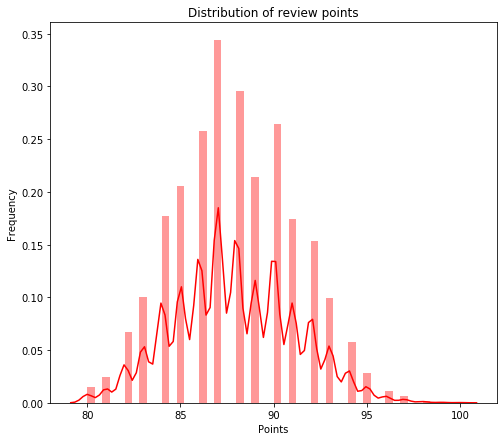

In [29]:
# Visualization: Distribution/Frequency of Points over five categories
plt.figure(figsize=(8,7))
sns.distplot(data['points'],color='red')
plt.title('Distribution of review points')
plt.xlabel('Points')
plt.ylabel('Frequency')

In [14]:
def points_to_class(points):
    if points in range(80,83):
        return 0
    elif points in range(83,87):
        return 1
    elif points in range(87,90):
        return 2
    elif points in range(90,94):
        return 3
    else:
        return 4
    
data["rating"] = data["points"].apply(points_to_class)

### Counting numbers of classes

In [61]:
sample_size = data.shape[0]
for i in range(0,5):
    x = data[data["rating"]==i].shape[0]
    p = x/sample_size
    print("Class {} has {} reviews, which is rougly {:.1%}".format(i,x,p))

Class 0 has 6441 reviews, which is rougly 4.3%
Class 1 has 44740 reviews, which is rougly 29.6%
Class 2 has 51539 reviews, which is rougly 34.1%
Class 3 has 41767 reviews, which is rougly 27.7%
Class 4 has 6443 reviews, which is rougly 4.3%


Based on the above distribution of classes, it is clearly that these are not balanced classes. It makes sense somehow as superb wines are rarer and therefore the number of reviews in this class is almost small. Weight per class is needed to reflect the nature of this type of dataset. The following weights for classes would be used in training the classifier:

Weight for class 0 = 7

Weight for class 1 = 1

Weight for class 2 = 1

Weight for class 3 = 1

Weight for class 4 = 7


### Visualization: Word Occurence in Review

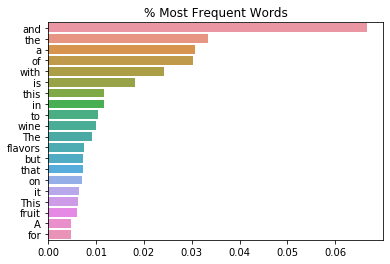

In [60]:
occurrence = data["description"].str.split(expand=True).stack().value_counts()

total = sum(occurrence)

# plot the most 20 common words 

top = occurrence[:20]/total

ax = sns.barplot(x = top.values, y = top.index)

# Setting title 
ax.set_title("% Most Frequent Words")

plt.show()

As one can see in the above plot, some stopwords appear in the list of most frequent words and clearly, these stopwords would not provide useful information. So removing stopwords is critical as it would help to improve the training models later. A preprocessing step is necessary and it is written in the file classify_wine.py. 

# Prediction function.

In [3]:
def test_prediction(class_weight,path="scripts/data/winemag-data_first150k.csv",
                    features_col="description",
                    target_col="points",
                    test_size=0.05,cv=5,random_state=42,ngram=(1,1),solver='sag'):
    # split dataset, then preprocessing texts for train set and development set
    dataset = classify_wine.DataToSeries(path,features_col,target_col, 
                                         test_size = test_size, random_state=random_state)
    raw_train_features, devel_features, raw_train_targets, raw_devel_targets = dataset
    train_features = classify_wine.preprocess_features(raw_train_features)
    train_targets = classify_wine.preprocess_targets(raw_train_targets)
    devel_targets = classify_wine.preprocess_targets(raw_devel_targets)    

    # create the feature extractor 
    to_features = classify_wine.TextToFeatures(train_features,ngram_range = ngram)

    # train the classifier on the training data
    classifier = classify_wine.Classifier(cv=cv, random_state = random_state, class_weight = class_weight, solver = solver)
    features = to_features(train_features)
    devel = to_features(devel_features)
    classifier.train(features, train_targets)

    # make predictions on the development data
    predicted_indices = classifier.predict(devel)
    
    return devel_targets, predicted_indices
    


In [5]:
class_weight = {0: 7,1: 1,2: 1, 3: 1,4: 7}  

In [31]:
# We test with unigrams first.
devel_targets, predicted_indices = test_prediction(class_weight=class_weight)

In [37]:
# measure performance of predictions for unigram model
accuracy = accuracy_score(devel_targets, predicted_indices)

print(f"\n{accuracy:.1%} accuracy on the development data")


72.1% accuracy on the development data


In [36]:
# Print the precision and recall, among other metrics for unigram model
    
print(metrics.classification_report(devel_targets, predicted_indices, digits=3))

              precision    recall  f1-score   support

           0      0.639     0.769     0.698       329
           1      0.783     0.738     0.760      2326
           2      0.686     0.691     0.689      2504
           3      0.745     0.727     0.736      2036
           4      0.583     0.736     0.651       352

   micro avg      0.721     0.721     0.721      7547
   macro avg      0.687     0.732     0.707      7547
weighted avg      0.725     0.721     0.722      7547



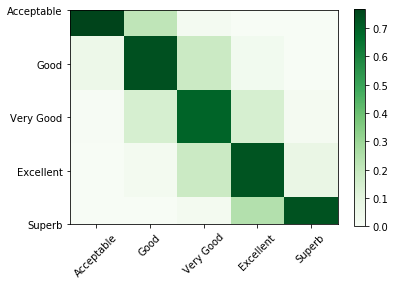

In [34]:
# Visualize the corresponding confusion matrix for unigram model
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(devel_targets, predicted_indices)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)

class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb"]

plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()

In [35]:
# Print the confusion matrix for unigram model
    
print(metrics.confusion_matrix(devel_targets, predicted_indices))

[[ 253   70    6    0    0]
 [ 124 1717  416   64    5]
 [  14  361 1731  359   39]
 [   5   46  363 1481  141]
 [   0    0    8   85  259]]


In [6]:
# In this part, we will try bigram instead of unigram.
devel_targets_2, predicted_indices_2 = test_prediction(class_weight=class_weight, ngram = (1,2))
accuracy = accuracy_score(devel_targets_2, predicted_indices_2)

print(f"\n{accuracy:.1%} accuracy on the development data with bigrams")


84.3% accuracy on the development data with bigrams


In [7]:
# Metric classification report for bigram model
print(metrics.classification_report(devel_targets_2, predicted_indices_2, digits=3))

              precision    recall  f1-score   support

           0      0.795     0.815     0.805       329
           1      0.873     0.862     0.867      2326
           2      0.821     0.831     0.826      2504
           3      0.842     0.860     0.851      2036
           4      0.854     0.733     0.789       352

   micro avg      0.843     0.843     0.843      7547
   macro avg      0.837     0.820     0.828      7547
weighted avg      0.843     0.843     0.843      7547



In [9]:
# Print the confusion matrix for bigram model
print("Confusion matrix for bigram model")    
print(metrics.confusion_matrix(devel_targets_2, predicted_indices_2))

Confusion matrix for bigram model
[[ 268   59    2    0    0]
 [  65 2004  228   27    2]
 [   3  207 2082  208    4]
 [   1   25  222 1750   38]
 [   0    0    1   93  258]]


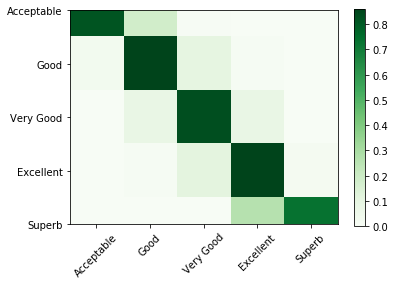

In [10]:
# Visualize the corresponding confusion matrix of bigram model
cm = confusion_matrix(devel_targets_2, predicted_indices_2)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)

class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb"]

plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()

Conclusion. Bigram model works better than unigram model. Cross Validation is necessary. From the confusion matrices, it seems that the models predict the classes of good, very good, excellent wines very well.